# Problem 1

This exercise asks you to implement and assess the performance of the bootstrap for the linear regression model. Suppose you have the linear regression model:

\begin{align*}
  y_{i} = \beta_{0} + \beta_{1}x_{i} + \epsilon_{i}
\end{align*}

where,

\begin{itemize}
  \item[-] $x_{i} \sim U[0,2]$
  \item[-] $\epsilon_{i} \vert x_{i} \sim U[-1,1]$
  \item[-] $\beta_{0} = \beta_{1} = 1$ 
\end{itemize}

We ask you to answer the following questions:

a. Write a code that generates i.i.d. samples of sizes $n=10,50,200$ from that distribution, computes (1) the least squares estimator for $\beta$, (2) the t-ratio for the least squares coefficient $\beta_{1}$, $t_{n} = \frac{\hat{\beta}_{1,LS} - 1}{\hat{s.e.}(\hat{\beta}_{1,LS})}$, and (3) the least square residuals $\hat{\epsilon}_{i} = y_{i} - \hat{\beta}_{0,LS} - \hat{\beta}_{1,LS} x_{i}$


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
class BootstrapSimulator:
    def __init__(self, n):
        self.n = n  # sample size

        self.df = pd.DataFrame()
        
        self.ols = None
        self.b0_ols = None
        self.b1_ols = None
        self.t_ols = None

    def draw_samples(self):
        n = self.n

        self.df['x'] = np.random.uniform(0, 2, n)
        self.df['e'] = np.random.uniform(-1, 1, n)
        self.df['y'] = 1 + self.df['x'] + self.df['e']
        self.df['intercept'] = np.ones(n)
        return self.df

    @staticmethod
    def get_ols_params(fitted_model):
        b_hat = fitted_model.params['x']
        b_se = fitted_model.bse['x']
        t = (b_hat - 1) / b_se
        return b_hat, t

    def fit_ols(self, y="y"):
        # fit model
        self.ols = sm.OLS(self.df[y], self.df[['x', 'intercept']]).fit()

        self.b1_ols, self.t_ols = self.get_ols_params(self.ols)
        self.b0_ols = self.ols.params['intercept']

        # residuals
        self.df['e_hat'] = self.df[y] - self.b0_ols - self.b1_ols * self.df['x']

        return self.b1_ols, self.t_ols

    def sample_residuals(self):
        n = len(self.df)
        return np.random.choice(self.df['e_hat'], n, replace=True)

    @staticmethod
    def get_bootstrap_stats(params):
        return {'ci': (np.percentile(params, 2.5), np.percentile(params, 97.5)),
                'mean': np.mean(params)}

    def residual_bootstrap(self, n_reps=200):

        b_bootstrap = list()
        t_bootstrap = list()

        stats = dict()

        for _ in range(n_reps):
            e_bootstrap = self.sample_residuals()
            self.df['y_bootstrap'] = self.b0_ols + self.b1_ols * self.df['x'] + e_bootstrap
            ols = sm.OLS(self.df["y_bootstrap"], self.df[['x', 'intercept']]).fit()
            b, t = self.get_ols_params(ols)
            b_bootstrap.append(b)
            t_bootstrap.append(t)

        stats['b'] = self.get_bootstrap_stats(b_bootstrap)
        stats['t'] = self.get_bootstrap_stats(t_bootstrap)

        return stats

    def parametric_bootstrap(self, n_reps=200):
        b_bootstrap = list()
        t_bootstrap = list()

        stats = dict()

        for _ in range(n_reps):
            self.df['e'] = np.random.uniform(-1, 1, self.n)
            self.df['y'] = self.b0_ols + self.b1_ols * self.df['x'] + self.df['e']
            ols = sm.OLS(self.df['y'], self.df[['x', 'intercept']]).fit()

            b, t = self.get_ols_params(ols)
            b_bootstrap.append(b)
            t_bootstrap.append(t)
        stats['b'] = self.get_bootstrap_stats(b_bootstrap)
        stats['t'] = self.get_bootstrap_stats(t_bootstrap)

        return stats


See `draw_samples` and `fit_ols` methods.

b. Write a code for drawing $n$ times at random from the discrete uniform distribution over the estimated residuals $\hat{\epsilon}_{1},...,\hat{\epsilon}_{n}$ (i.e. with replacement).

See `sample_residuals` method in `BootstrapSimulator` class.

c. Use your code from parts (a) and (b) to implement the residual bootstrap - assuming that $\epsilon_{i}$ and $x_{i}$ are independent - to estimate the 95th percentiles of the respective distributions of $\hat{\beta}_{1,LS}$ and $t_{n}$


In [3]:
bs_10 = BootstrapSimulator(n=10)
bs_50 = BootstrapSimulator(n=50)
bs_200 = BootstrapSimulator(n=200)

bs_10.draw_samples()
bs_10.fit_ols()

bs_50.draw_samples()
bs_50.fit_ols()

bs_200.draw_samples()
bs_200.fit_ols()

(0.9850883905439032, -0.19459470136382742)

In [4]:
# Residual bootstrap 
res_10 = bs_10.residual_bootstrap()
res_50 = bs_50.residual_bootstrap()
res_200 = bs_200.residual_bootstrap()


In [5]:
df_res = pd.DataFrame([res_10, res_50, res_200])

print('b estimates')
print(df_res['b'].apply(pd.Series))

print('t estimates')
print(df_res['t'].apply(pd.Series))

b estimates
                                         ci      mean
0  (0.1252409779586813, 0.8744245281189442)  0.497854
1  (0.7564703092768035, 1.3095184865086547)  1.024620
2  (0.8415242880163574, 1.1121380817466304)  0.975943
t estimates
                                           ci      mean
0  (-4.9693357957442394, -0.5040697930336879) -2.357089
1    (-1.8305105346400985, 2.240661045221299)  0.177186
2     (-2.016877673129661, 1.467179807545017) -0.316971


d. Repeat part (a) for sample size $n=10,50,200$ with $200$ replications, where you keep the initial draws of $x_{1},..,x_{n}$ from part (a) and only generate new residuals from their conditional distribution. Compute $\hat{\beta}_{1,LS}$ and the statistic $t_{n}$ using $200$ independent samples of size $n$. Use your results to compute a simulated estimate for the 95th percentiles of the respective sampling distributions for $\hat{\beta}_{1,LS}$ and $t_{n}$.


In [6]:
# parametric bootstrap
par_10 = bs_10.parametric_bootstrap()
par_50 = bs_50.parametric_bootstrap()
par_200 = bs_200.parametric_bootstrap()


In [7]:
df_par = pd.DataFrame([par_10, par_50, par_200])

print('b estimates')
print(df_par['b'].apply(pd.Series))

print('t estimates')
print(df_par['t'].apply(pd.Series))

b estimates
                                           ci      mean
0  (-0.07770851234812026, 1.0908798535407562)  0.481773
1    (0.7336699250353068, 1.2440893219167681)  1.014423
2    (0.8299080953533149, 1.1223787253665154)  0.985627
t estimates
                                          ci      mean
0   (-4.249443952035807, 0.3108292477213074) -1.776718
1  (-2.0759239890186234, 1.7110379456127023)  0.091293
2  (-2.3983362460727142, 1.6721542243509722) -0.196839


e. Compare your results from (c) and (d). What do you conclude about the performance of the bootstrap? How does it compare to the 95th percentile of the asymptotic distribution of $t_{n}$?

Both residual (c) and parametric (d) bootstrap give similar results for $beta$ estimates. For $t$ estimates, they are different for n=2, but tend to converge for higher n.   


In [8]:
def get_asymptotic_ci(bs_sim, stat):
    if stat == "b":
        return (bs_sim.ols.params['x'] - 2*bs_sim.ols.bse['x'], bs_sim.ols.params['x'] + 2*bs_sim.ols.bse['x'])
    elif stat == "t":
        return (((bs_sim.ols.params['x'] - 2*bs_sim.ols.bse['x']) - 1)/bs_sim.ols.bse['x'], ((bs_sim.ols.params['x'] + 2*bs_sim.ols.bse['x']) - 1)/bs_sim.ols.bse['x'])

For, $\hat{\beta}_1$, note that the bootstrap CI are fairly close to asymptotic distribution CI:

In [9]:
print(get_asymptotic_ci(bs_10, stat="b"))
print(get_asymptotic_ci(bs_50, stat="b"))
print(get_asymptotic_ci(bs_200, stat="b"))

(0.0012296909768160225, 1.0016978646647163)
(0.7340372030038689, 1.3007819814839865)
(0.831830266334066, 1.1383465147537404)


To get asymptotic distribution of $t_n$, we would have to rely on the delta method. But since $\beta_1$ and $se(beta_1)$ are independent, we can do a simple substitution. The bootstrap estimates converge for larger n.     

In [10]:
print(get_asymptotic_ci(bs_10, stat="t"))
print(get_asymptotic_ci(bs_50, stat="t"))
print(get_asymptotic_ci(bs_200, stat="t"))

(-3.9932117194354806, 0.00678828056451893)
(-1.877125698162645, 2.122874301837354)
(-2.1945947013638274, 1.8054052986361726)


# Problem 2

This exercise will walk you through a prediction task. I have downloaded data from a peer-to-peer lending platform, Lending Club. The dataset you will work with is: __lending_club_07_to_11_cleaned.csv__. Lending Club provides detailed characteristic information regarding loans, both information on the borrower, as well as, the loan itself. Your goal will be to build a model to predict the outcome of a loan, i.e. whether an individual paid off a loan or did not pay off a loan. In our case, a good outcome is if the loan is fully paid off, a bad outcome is if the loan is charged off. 

The target variable for the analysis is **loan_status**, where:

\begin{align*}
  loan\_status = 
    \begin{cases}
      1 \mbox{ if loan is paid off } \\
      0 \mbox{ if loan is not paid off }
    \end{cases}
\end{align*}


In [11]:
import pandas as pd

df = pd.read_csv("data/lending_club_07_to_11_cleaned.csv")

a. This is going to be a more DIY style exercise, provide a list of the variables you plan to use for the analysis. Give a short discussion for why you excluded other variables.


In [12]:
vars_to_include = ["addr_state", 
                   "annual_inc", 
                   "delinq_2yrs",
                   "dti",
                   "emp_length",
                   "funded_amnt",
                   "home_ownership",
                   "inq_last_6mths",
                   "installment",
                   "int_rate",
                   'loan_amnt',
                   'open_acc',
                   'pub_rec',
                   'pub_rec_bankruptcies',
                   'purpose',
                   'revol_bal', 
                   'revol_util',
                   'sub_grade',
                   'term',
                   'total_acc',
                   'total_pymnt',
                   'total_rec_int',
                   'total_rec_late_fee',
                   'total_rec_prncp',
                   'verification_status',
                   'zip_code']

In [13]:
# convert to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')


In [14]:
# create new features
df['days_since_first_cr_line'] = (df['issue_d'] - df['earliest_cr_line']).apply(lambda x: x.days)
df['days_since_last_pymnt'] = (datetime.today() - df['last_pymnt_d']).apply(lambda x: x.days)
df['days_since_last_cr_pull'] = (datetime.today() - df['last_credit_pull_d']).apply(lambda x: x.days)


In [15]:
vars_to_include.extend(['days_since_first_cr_line', 'days_since_last_pymnt', 'days_since_last_cr_pull'])

In [16]:
df[vars_to_include].dtypes

addr_state                   object
annual_inc                  float64
delinq_2yrs                   int64
dti                         float64
emp_length                   object
funded_amnt                   int64
home_ownership               object
inq_last_6mths                int64
installment                 float64
int_rate                     object
loan_amnt                     int64
open_acc                      int64
pub_rec                       int64
pub_rec_bankruptcies        float64
purpose                      object
revol_bal                     int64
revol_util                   object
sub_grade                    object
term                         object
total_acc                     int64
total_pymnt                 float64
total_rec_int               float64
total_rec_late_fee          float64
total_rec_prncp             float64
verification_status          object
zip_code                     object
days_since_first_cr_line      int64
days_since_last_pymnt       

In [17]:
# convert to proper data types
df['int_rate'] = df['int_rate'].apply(lambda x: float(x[:-1]) if x is not np.nan else x)
df['revol_util'] = df['revol_util'].apply(lambda x: float(x[:-1]) if x is not np.nan else x)

The following variables are ommitted, because there is no variance in the data: `acc_now_delinq, chargeoff_within_12_mths, collections_12_mths_ex_med, delinq_amnt, disbursement method, hardship_flag, initial_list_status, out_prncp, out_prncp_inv, policy_code, pymnt_plan, tax_liens`.

The following variables are omitted because it is not in the data dictionary, and I can't infer what they mean: `collection_recovery_fee, debt_settlement_flag, funded_amnt_inv, total_pymnt_inv, recoveries`.

`grade` is fully capture in `sub_grade`. 

Instead of including, `issue_d, earliest_cr_line, last_credit_pull_d, last_pymnt_d`, I included 3 transformed features: `days_since_first_cr_line, days_since_last_pymnt, days_since_last_pymnt`


b.  Regularization is an important step when using an machine learning algorithm, regularzie the variables that you have included. Briefly, why is regularization important?

Regularization centers and scales the data. It helps with gradient descent convergence as the gradient surface won't be skewed in any particular dimension  

In [18]:
data = df[vars_to_include+['loan_status']]
data = data.dropna().reset_index(drop=True)

X = data[vars_to_include]

In [19]:
from sklearn.preprocessing import StandardScaler

data = df[vars_to_include+['loan_status']]
data = data.dropna().reset_index(drop=True)

X = data[vars_to_include]
y = data['loan_status']
# get numeric column types

numeric_cols = [k for k,v in X.dtypes.to_dict().items() if v in [int, float]]
print(numeric_cols)
scaler = StandardScaler()

X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


['annual_inc', 'delinq_2yrs', 'dti', 'funded_amnt', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'days_since_first_cr_line', 'days_since_last_pymnt', 'days_since_last_cr_pull']


/Users/parasu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/parasu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


c. Provide a simple correlational table to give you a sense of the relationship between your covariates. Do you notice any interesting patterns?


In [20]:
import seaborn as sns

cor_table = X[numeric_cols].corr()

cor_table

annual_inc  delinq_2yrs       dti  funded_amnt  \
annual_inc                  1.000000     0.022445 -0.124681     0.268287   
delinq_2yrs                 0.022445     1.000000 -0.036118    -0.034389   
dti                        -0.124681    -0.036118  1.000000     0.065301   
funded_amnt                 0.268287    -0.034389  0.065301     1.000000   
inq_last_6mths              0.033472     0.007069 -0.000236     0.007624   
installment                 0.272153    -0.022195  0.053239     0.955391   
int_rate                    0.052448     0.158380  0.108273     0.313052   
loan_amnt                   0.272296    -0.033730  0.065034     0.981301   
open_acc                    0.157171     0.011986  0.290514     0.172354   
pub_rec                    -0.015147     0.009970 -0.005554    -0.048898   
pub_rec_bankruptcies       -0.012931     0.004945  0.005774    -0.034133   
revol_bal                   0.279054    -0.056674  0.228631     0.313264   
revol_util                  0.017173    -0.044628  0.276073     0.069696   
total_acc                   0.237203     0.068196  0.229083     0.249831   
total_pymnt                 0.257571    -0.023685  0.064530     0.903647   
total_rec_int               0.185332     0.022342  0.104411     0.736995   
total_rec_late_fee          0.008124     0.033372 -0.010295     0.052480   
total_rec_prncp             0.259872    -0.039953  0.041901     0.874004   
days_since_first_cr_line    0.180313     0.064830  0.050192     0.193477   
days_since_last_pymnt      -0.015844     0.005000 -0.097698    -0.146958   
days_since_last_cr_pull     0.010625    -0.007269 -0.119076    -0.042719   

                          inq_last_6mths  installment  int_rate  loan_amnt  \
annual_inc                      0.033472     0.272153  0.052448   0.272296   
delinq_2yrs                     0.007069    -0.022195  0.158380  -0.033730   
dti                            -0.000236     0.053239  0.108273   0.065034   
funded_amnt                     0.007624     0.955391  0.313052   0.981301   
inq_last_6mths                  1.000000     0.007526  0.134738   0.007576   
installment                     0.007526     1.000000  0.282471   0.929132   
int_rate                        0.134738     0.282471  1.000000   0.309604   
loan_amnt                       0.007576     0.929132  0.309604   1.000000   
open_acc                        0.092757     0.169679  0.013577   0.173914   
pub_rec                         0.024603    -0.043192  0.097092  -0.048105   
pub_rec_bankruptcies            0.015048    -0.029963  0.082078  -0.032866   
revol_bal                      -0.025706     0.315640  0.100515   0.320136   
revol_util                     -0.068598     0.095136  0.465695   0.065284   
total_acc                       0.113206     0.230644 -0.042612   0.255719   
total_pymnt                    -0.010114     0.854238  0.313651   0.886746   
total_rec_int                   0.023080     0.632747  0.531746   0.729106   
total_rec_late_fee              0.029547     0.059798  0.100839   0.050447   
total_rec_prncp                -0.023412     0.851132  0.193289   0.855311   
days_since_first_cr_line        0.006994     0.169246 -0.093930   0.199594   
days_since_last_pymnt           0.073552    -0.043235 -0.102115  -0.146459   
days_since_last_cr_pull        -0.025196    -0.019885 -0.119939  -0.039591   

                          open_acc   pub_rec  ...  revol_bal  revol_util  \
annual_inc                0.157171 -0.015147  ...   0.279054    0.017173   
delinq_2yrs               0.011986  0.009970  ...  -0.056674   -0.044628   
dti                       0.290514 -0.005554  ...   0.228631    0.276073   
funded_amnt               0.172354 -0.048898  ...   0.313264    0.069696   
inq_last_6mths            0.092757  0.024603  ...  -0.025706   -0.068598   
installment               0.169679 -0.043192  ...   0.315640    0.095136   
int_rate                  0.013577  0.097092  ...   0.100515    0.465695   
loan_amnt                 0.

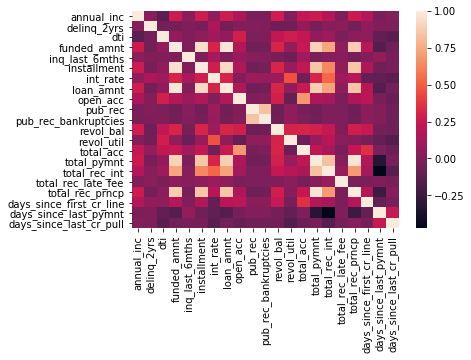

In [21]:
sns.heatmap(X[numeric_cols].corr())

In [22]:
X[['total_rec_prncp', 'total_pymnt']].corr()

total_rec_prncp  total_pymnt
total_rec_prncp         1.000000     0.971794
total_pymnt             0.971794     1.000000

There are some almost perfect correlation, for example total_rec_prncp, which we can take out. 

In [23]:
X = X.drop('total_rec_prncp', axis=1)

d. Split the dataset into a single test and training set, a simple rule of thumb is an 40/60 split. How did you build these two sets?

In [24]:
from sklearn.model_selection import train_test_split

# firt convert categorical cols to dummies
cat_cols = [k for k,v in X.dtypes.to_dict().items() if v in [object]]
dummy = pd.get_dummies(X[cat_cols])
X = pd.concat([X, dummy], axis=1)
X = X.drop(cat_cols, axis=1)

In [25]:
X.shape

(37901, 947)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

e. Using your training set, run a logistic regression, a random forest, and a gradient boosted random forest. To show your results, present both a measure of miscalssification error, accuracy and a confusion matrix.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf = RandomForestClassifier()
logit = LogisticRegression()
rfgb = GradientBoostingClassifier()

/Users/parasu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)
rfgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [29]:
def get_metrics(model):
    print(model)
    print("accuracy")
    print(accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    print("Confusion matrix")
    print(confusion_matrix(y_pred=model.predict(X_test), y_true=y_test))
    print('\n\n')

In [30]:
for m in (rf, logit, rfgb):
    get_metrics(m)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy
0.9389881933909373
Confusion matrix
[[ 1251   840]
 [   85 12985]]



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy
0.9827847767297672
Confusion matrix
[[ 1832   259]
 [    2 13068]]



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=No

The accuracy seems suspiciously high (the baserate for paid off loan is 86%). Maybe there's leakage from one of the included variables.   

f. One easy way to improve model performance is cross-validation. Do a k-fold cross validation, where k=5, using the best performing model from part (e.). Re-report the misclassification error, accuracy and a confusion matrix. 

In [31]:
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

In [32]:
# accuracies
cross_val_score(logit, X, y, cv=5)

array([0.98720485, 0.98680913, 0.98562005, 0.98139842, 0.98113208])

In [33]:
confusion_matrix(y_pred=cross_val_predict(logit, X, y, cv=5), y_true=y)

array([[ 4663,   581],
       [    9, 32648]])